In [1]:
import os
import cv2
import numpy as np
import shutil
from sklearn.model_selection import train_test_split # to split the training set and create the validation set
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from tensorflow.keras.models import load_model
from shutil import copyfile
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


2025-02-19 17:54:12.587504: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-19 17:54:12.599670: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739984052.614863  118445 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739984052.618294  118445 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-19 17:54:12.631425: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

### Preparazione dei dati

In [2]:
train_dir = "/mnt/c/Users/carlo/Desktop/MAGISTRALE/MACHINE LEARNING/PROGETTO/chest_xray/train"
validation_dir = "/mnt/c/Users/carlo/Desktop/MAGISTRALE/MACHINE LEARNING/PROGETTO/chest_xray/validation"
test_dir = "/mnt/c/Users/carlo/Desktop/MAGISTRALE/MACHINE LEARNING/PROGETTO/chest_xray/test"

Vediamo alcuni esempi di radiografie di persone sane e di persone con la polmonite

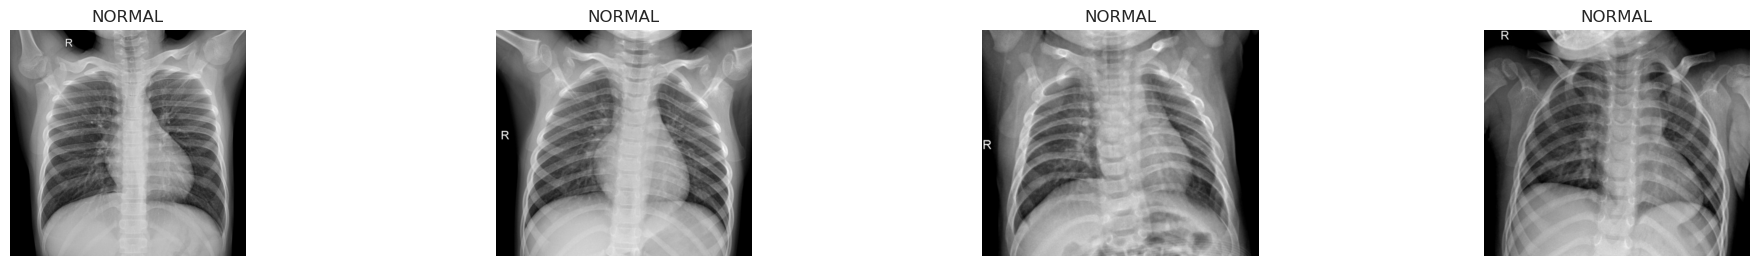

In [36]:
plt.figure(figsize=(20, 10))
directory = "/mnt/c/Users/carlo/Desktop/MAGISTRALE/MACHINE LEARNING/PROGETTO/chest_xray/train/NORMAL"
for i in range(4):
    plt.subplot(4, 4, i + 1)
    images = os.listdir(directory)
    img = plt.imread(os.path.join(directory, images[i]))
    plt.imshow(img, cmap='gray')# Display the image in grayscale
    plt.axis('off') # Hide the axis for better visualization
    plt.title("NORMAL") # Set the title for the image
plt.tight_layout()# Adjust layout to avoid overlapping elements

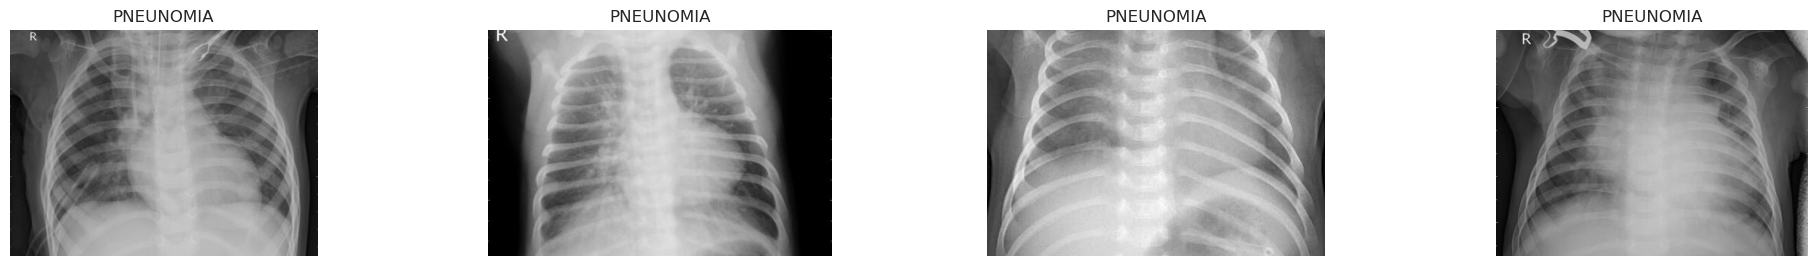

In [37]:
plt.figure(figsize=(20, 10))
directory = "/mnt/c/Users/carlo/Desktop/MAGISTRALE/MACHINE LEARNING/PROGETTO/chest_xray/train/PNEUMONIA"
for i in range(4):
    plt.subplot(4, 4, i + 1)
    images = os.listdir(directory)
    img = plt.imread(os.path.join(directory, images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("PNEUNOMIA")
plt.tight_layout()

##### Create Validation set

In [3]:
labels = ["PNEUMONIA", "NORMAL"]

# Create the validation directory if it does not exist
if not os.path.exists(validation_dir):
    os.makedirs(validation_dir)

    for label in labels:
        # Paths for each class
        class_train_dir = os.path.join(train_dir, label)
        class_validation_dir = os.path.join(validation_dir, label)

        # Create directories for the classes in validation if they do not exist
        if not os.path.exists(class_validation_dir):
            os.makedirs(class_validation_dir)

        # Get all files of the class
        files = os.listdir(class_train_dir)
        files = [os.path.join(class_train_dir, file) for file in files if file.endswith(('.png', '.jpg', '.jpeg'))]

        # Split files into training and validation (80% train, 20% validation)
        train_files, val_files = train_test_split(files, test_size=0.2, random_state=42)

        # Move validation files to the corresponding folder
        for file in val_files:
            shutil.move(file, os.path.join(class_validation_dir, os.path.basename(file)))

        print(f"Classe '{label}': {len(train_files)} file nel training set, {len(val_files)} file nel validation set")

##### Distribuzione dei dati

<Axes: ylabel='count'>

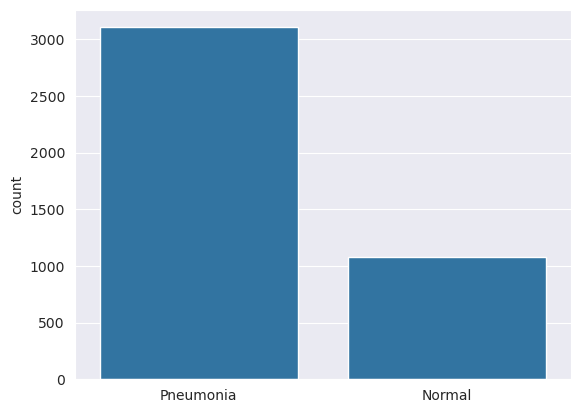

In [17]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_data(data_dir):
    # data = []
    labels_list = []

    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)  # Assegna 0 a NORMAL e 1 a PNEUMONIA
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                # resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Ridimensiona l'immagine
                # data.append(resized_arr)  # Aggiunge solo l'immagine
                labels_list.append(class_num)  # Aggiunge la classe separatamente
            except Exception as e:
                print(e)
    return np.array(labels_list)  # Restituisce due array separati


train_labels = get_data(train_dir)
# Conta le immagini per classe
label_counts = {0: "Pneumonia", 1: "Normal"}
class_labels = [label_counts[label] for label in train_labels]

sns.set_style("darkgrid")
sns.countplot(x=class_labels)


Come possiamo vedere il dataset risulta sbilanciato, in quanto la classe "NORMAL" ha molti campioni in meno. Per sopperire a questo problema useremo data augmentation. 

In [3]:
img_height, img_width = 224, 224

### First Data Augmentation

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),  # Resize each image
    color_mode="grayscale",  # <-- IMPOSTA SCALA DI GRIGI
    batch_size=32, # Number of images per batch
    class_mode='binary' # label type
)


Found 4185 images belonging to 2 classes.


We plot an example of a data augmentation

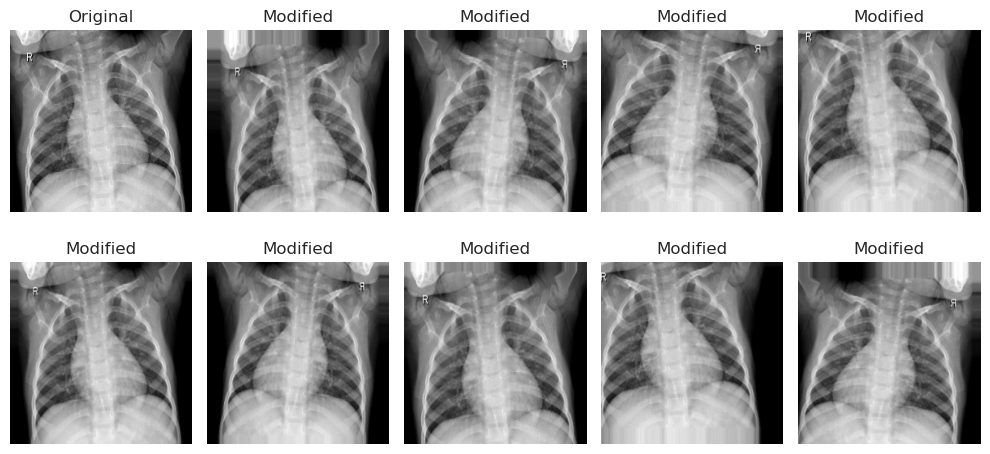

In [38]:
# Upload a single image
img_path = "/mnt/c/Users/carlo/Desktop/MAGISTRALE/MACHINE LEARNING/PROGETTO/chest_xray/train/NORMAL/NORMAL-32326-0001.jpeg"
img = image.load_img(img_path, target_size=(224, 224))

img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Generate augmented images
augmented_images = train_datagen.flow(img_array, batch_size=1)

plt.figure(figsize=(10, 5))

# Show original image
plt.subplot(2, 5, 1)
plt.imshow(img)
plt.axis('off')
plt.title("Original")

# Generate and display 9 augmented images
for i in range(9):
    batch = next(augmented_images)  # Get a transformed image
    plt.subplot(2, 5, i + 2)
    plt.imshow(batch[0])  # batch[0] because it's a batch of a single image
    plt.title("Modified")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [5]:

evaluate_datagen = ImageDataGenerator(
    rescale=1./255, #pixel normalization between 0 and 1
)

valid_generator = evaluate_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),  # Resize each image
    color_mode="grayscale",  # <-- IMPOSTA SCALA DI GRIGI
    batch_size=32, # Number of images per batch
    class_mode='binary' # label type
)

test_generator = evaluate_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),  # Resize each image
    color_mode="grayscale",  # <-- IMPOSTA SCALA DI GRIGI    
    shuffle=False,  # Importante per mantenere l'ordine delle immagini
    batch_size=32, # Number of images per batch
    class_mode='binary' # label type
)

Found 1047 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


#### Creazione del modello

In [6]:

cnn_model = keras.models.Sequential([
    keras.layers.Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu', input_shape=(img_height, img_width, 1)),#Aggiunge uno strato convoluzionale bidimensionale con 32 filtri, ciascuno di dimensione 3x3
    keras.layers.MaxPooling2D((2,2) , strides = 2 , padding = 'same'), #Aggiunge uno strato di pooling massimo bidimensionale con una finestra di 2x2
    
    keras.layers.Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    keras.layers.MaxPooling2D((2,2) , strides = 2 , padding = 'same'),
    
    keras.layers.Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    keras.layers.MaxPooling2D((2,2) , strides = 2 , padding = 'same'),
    
    keras.layers.Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    keras.layers.MaxPooling2D((2,2) , strides = 2 , padding = 'same'),
    
    keras.layers.Flatten(), #Converte l'output tridimensionale degli strati precedenti in un vettore unidimensionale, preparandolo per gli strati densi successivi
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')
])

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()]
)

cnn_model.summary()

/home/carlos/miniconda3/envs/ML/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1739984064.956878  118445 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,341,121 (12.75 MB)

 Trainable params: 3,341,121 (12.75 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1)

In [8]:
epochs=100
history = cnn_model.fit(train_generator, epochs=epochs, validation_data=valid_generator, callbacks=[early_stopping])

/home/carlos/miniconda3/envs/ML/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1739984071.641290  118624 service.cc:148] XLA service 0x7fb92801ce00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739984071.641327  118624 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-02-19 17:54:31.662795: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739984071.804289  118624 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/131 ━━━━━━━━━━━━━━━━━━━━ 13:26 6s/step - binary_accuracy: 0.8125 - loss: 0.6840

I0000 00:00:1739984076.819285  118624 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


131/131 ━━━━━━━━━━━━━━━━━━━━ 42s 273ms/step - binary_accuracy: 0.7749 - loss: 0.5274 - val_binary_accuracy: 0.9160 - val_loss: 0.2390
Epoch 2/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 29s 221ms/step - binary_accuracy: 0.8944 - loss: 0.2533 - val_binary_accuracy: 0.9179 - val_loss: 0.1919
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 29s 225ms/step - binary_accuracy: 0.9105 - loss: 0.2158 - val_binary_accuracy: 0.9408 - val_loss: 0.1629
Epoch 4/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 29s 219ms/step - binary_accuracy: 0.9302 - loss: 0.1669 - val_binary_accuracy: 0.9475 - val_loss: 0.1393
Epoch 5/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 25s 194ms/step - binary_accuracy: 0.9228 - loss: 0.1956 - val_binary_accuracy: 0.9255 - val_loss: 0.1803
Epoch 6/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 28s 190ms/step - binary_accuracy: 0.9425 - loss: 0.1606 - val_binary_accuracy: 0.9408 - val_loss: 0.1466
Epoch 7/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 29s 219ms/step - binary_accuracy: 0.9430 - loss: 0.1520 - val_binary_accuracy: 0.9561 - val_los

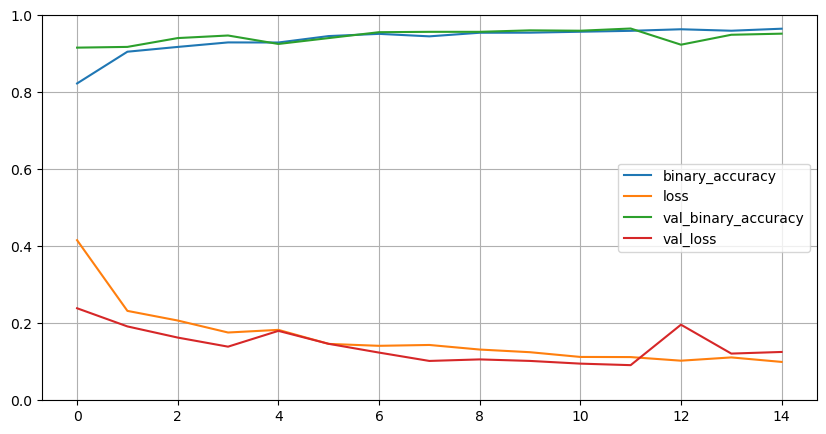

In [9]:
pd.DataFrame(history.history).plot(figsize=(10, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [17]:
cnn_model.save('/mnt/c/Users/carlo/Desktop/MAGISTRALE/MACHINE LEARNING/PROGETTO/CNN1.keras')  # Salva il modello in locale

### Second Data Augmentation

In [4]:
train_datagen2 = ImageDataGenerator(
    rescale=1./255,  # Normalizza i pixel tra 0 e 1
    rotation_range=15,  # Ridotta la rotazione per evitare distorsioni eccessive
    width_shift_range=0.2,  # Shift orizzontale fino al 10%
    height_shift_range=0.2,  # Shift verticale fino al 10%
    zoom_range=0.2,  # Zoom fino al 10%
    horizontal_flip=True,  # Mantiene il flip orizzontale
    brightness_range=[0.8, 1.2],  # Aggiunta variazione di luminosità ±20%
)

train_generator2 = train_datagen2.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),  # Resize each image
    color_mode="grayscale",  # <-- IMPOSTA SCALA DI GRIGI
    batch_size=32, # Number of images per batch
    class_mode='binary' # label type
)

Found 4185 images belonging to 2 classes.


In [ ]:
cnn_model2 = keras.models.Sequential([
    keras.layers.Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu', input_shape=(img_height, img_width, 1)),#Aggiunge uno strato convoluzionale bidimensionale con 32 filtri, ciascuno di dimensione 3x3
    keras.layers.MaxPooling2D((2,2) , strides = 2 , padding = 'same'), #Aggiunge uno strato di pooling massimo bidimensionale con una finestra di 2x2
    
    keras.layers.Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    keras.layers.MaxPooling2D((2,2) , strides = 2 , padding = 'same'),
    
    keras.layers.Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    keras.layers.MaxPooling2D((2,2) , strides = 2 , padding = 'same'),
    
    keras.layers.Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    keras.layers.MaxPooling2D((2,2) , strides = 2 , padding = 'same'),
    
    keras.layers.Flatten(), #Converte l'output tridimensionale degli strati precedenti in un vettore unidimensionale, preparandolo per gli strati densi successivi
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')
])

cnn_model2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()]
)

cnn_model2.summary()

In [9]:
epochs=100
history2 = cnn_model.fit(train_generator2, epochs=epochs, validation_data=valid_generator, callbacks=[early_stopping])

/home/carlos/miniconda3/envs/ML/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1739982936.909126  114005 service.cc:148] XLA service 0x7fda3000cd00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739982936.909163  114005 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-02-19 17:35:36.930260: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739982937.067376  114005 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/131 ━━━━━━━━━━━━━━━━━━━━ 13:45 6s/step - binary_accuracy: 0.6250 - loss: 0.6925

I0000 00:00:1739982942.190762  114005 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


118/131 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - binary_accuracy: 0.7730 - loss: 0.4925

2025-02-19 17:36:06.126301: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng28{k2=0,k13=2,k14=3,k18=0,k23=0} for conv (f32[25,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-02-19 17:36:06.126668: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.938172774s
Trying algorithm eng28{k2=0,k13=2,k14=3,k18=0,k23=0} for conv (f32[25,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", b

131/131 ━━━━━━━━━━━━━━━━━━━━ 42s 271ms/step - binary_accuracy: 0.7780 - loss: 0.4825 - val_binary_accuracy: 0.7956 - val_loss: 0.4277
Epoch 2/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 29s 222ms/step - binary_accuracy: 0.8880 - loss: 0.2709 - val_binary_accuracy: 0.9045 - val_loss: 0.2417
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 41s 220ms/step - binary_accuracy: 0.8918 - loss: 0.2686 - val_binary_accuracy: 0.8720 - val_loss: 0.2694
Epoch 4/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 29s 224ms/step - binary_accuracy: 0.8972 - loss: 0.2380 - val_binary_accuracy: 0.8185 - val_loss: 0.3642
Epoch 5/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 30s 227ms/step - binary_accuracy: 0.8992 - loss: 0.2399 - val_binary_accuracy: 0.9102 - val_loss: 0.2228
Epoch 6/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 26s 197ms/step - binary_accuracy: 0.9068 - loss: 0.2395 - val_binary_accuracy: 0.8902 - val_loss: 0.2421
Epoch 7/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 29s 224ms/step - binary_accuracy: 0.9074 - loss: 0.2242 - val_binary_accuracy: 0.9226 - val_los

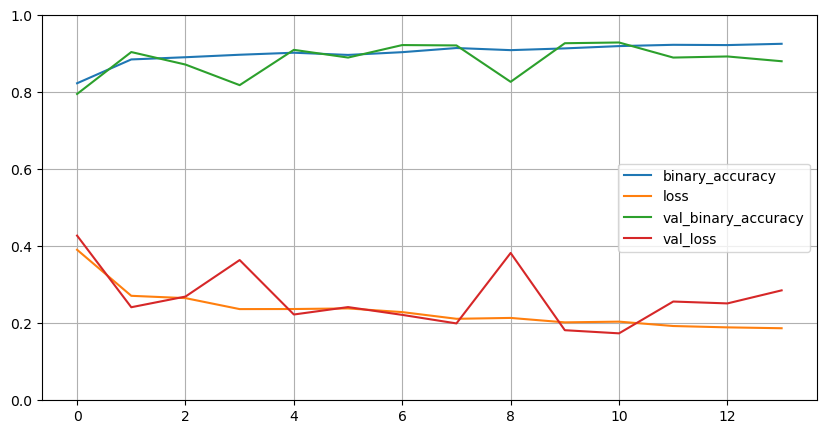

In [10]:
pd.DataFrame(history2.history).plot(figsize=(10, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [14]:
cnn_model.save('/mnt/c/Users/carlo/Desktop/MAGISTRALE/MACHINE LEARNING/PROGETTO/CNN2.keras')  # Salva il modello in locale

### Testing

Testiamo per primo il modello con il primo tipo di data augmentation

In [21]:
cnn_model= load_model('/mnt/c/Users/carlo/Desktop/MAGISTRALE/MACHINE LEARNING/PROGETTO/CNN1.keras')

In [22]:
### modello con prima forma di data augmentation
evaluation = cnn_model.evaluate(test_generator)
accuracy1 = evaluation[1]
loss1 = evaluation[0]
print(f"Test Accuracy: {accuracy1* 100:.2f}%")
print(f"Test Loss: {loss1}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - binary_accuracy: 0.7776 - loss: 0.4694
Test Accuracy: 87.98%
Test Loss: 0.28477713465690613


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step
              precision    recall  f1-score   support

      NORMAL       0.98      0.69      0.81       234
   PNEUMONIA       0.84      0.99      0.91       390

    accuracy                           0.88       624
   macro avg       0.91      0.84      0.86       624
weighted avg       0.90      0.88      0.87       624



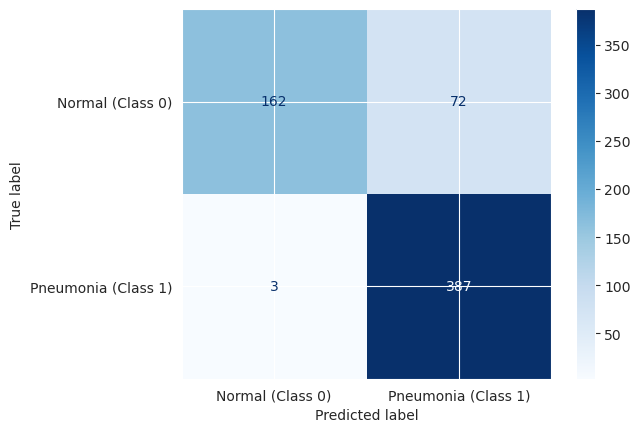

In [23]:
### modello con prima forma di data augmentation
batch_size=32

predictions = cnn_model.predict(test_generator, steps=test_generator.samples // batch_size + 1)
predicted_classes = (predictions > 0.5).astype(int)  # Converte le probabilità in classi binarie
y_test = test_generator.classes
# Calcola il report di classificazione
report = classification_report(y_test, predicted_classes, target_names=test_generator.class_indices.keys())
print(report)

cm = confusion_matrix(y_test, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal (Class 0)', 'Pneumonia (Class 1)'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Dopodiché testiamo il modello addestrato con il secondo tipo di data augmentation

In [29]:
cnn_model2= load_model('/mnt/c/Users/carlo/Desktop/MAGISTRALE/MACHINE LEARNING/PROGETTO/CNN2.keras')

In [30]:
### modello con seconda forma di data augmentation
evaluation2 = cnn_model2.evaluate(test_generator)
accuracy2 = evaluation2[1]
loss2 = evaluation2[0]
print(f"Test Accuracy: {accuracy2 * 100:.2f}%")
print(f"Test Loss: {loss2}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - binary_accuracy: 0.7447 - loss: 0.5594
Test Accuracy: 84.94%
Test Loss: 0.3547317087650299


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step
              precision    recall  f1-score   support

      NORMAL       0.91      0.67      0.77       234
   PNEUMONIA       0.83      0.96      0.89       390

    accuracy                           0.85       624
   macro avg       0.87      0.81      0.83       624
weighted avg       0.86      0.85      0.84       624



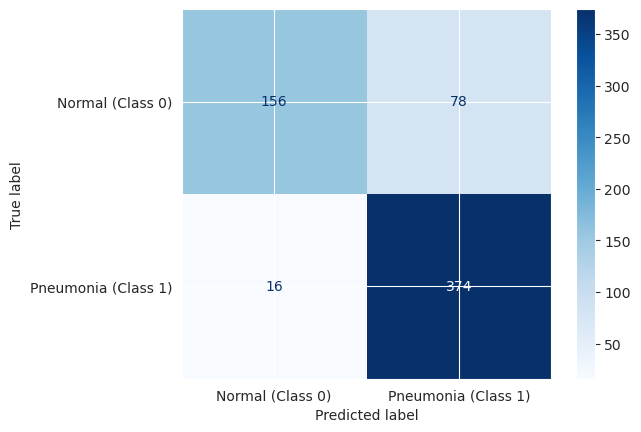

In [31]:
### modello con seconda forma di data augmentation
batch_size=32

predictions = cnn_model2.predict(test_generator, steps=test_generator.samples // batch_size + 1)
predicted_classes = (predictions > 0.5).astype(int)  # Converte le probabilità in classi binarie
y_test = test_generator.classes
# Calcola il report di classificazione
report = classification_report(y_test, predicted_classes, target_names=test_generator.class_indices.keys())
print(report)

cm = confusion_matrix(y_test, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal (Class 0)', 'Pneumonia (Class 1)'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Possiamo vedere che il secondo tipo di data augmentation causa delle prestazioni peggiori rispetto al primo, in quanto altera troppo le immagini, mentre il primo apporta leggere modifiche che permettono al modello di generalizzare meglio, ma senza alterare la natura delle radiografie.

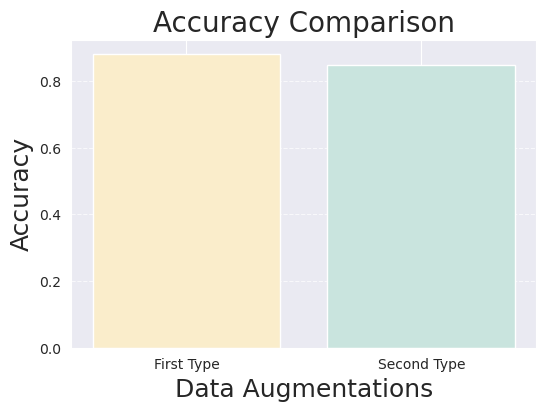

In [33]:
models = ['First Type', 'Second Type']
accuracy = [accuracy1, accuracy2]
loss = [loss1, loss2]

# Accuracy plot
plt.figure(figsize=(6, 4))
bars = plt.bar(models, accuracy, color=['#faedcb','#c9e4de'])
plt.xlabel('Data Augmentations', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.title('Accuracy Comparison', fontsize = 20)
plt.grid(axis = "y", linestyle = "--", alpha = 0.7)
plt.show() 

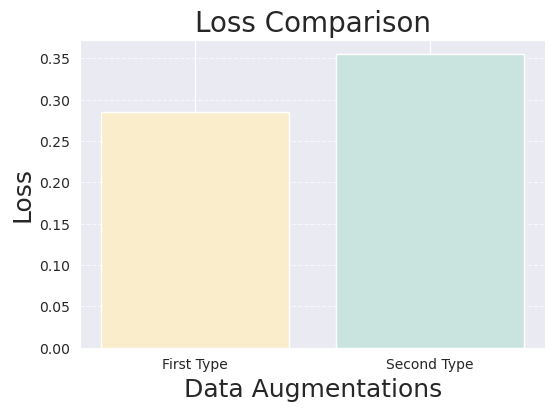

In [35]:
# Loss plot
plt.figure(figsize=(6, 4))
bars = plt.bar(models, loss, color=['#faedcb','#c9e4de'])
plt.xlabel('Data Augmentations', fontsize = 18)
plt.ylabel('Loss', fontsize = 18)
plt.title('Loss Comparison', fontsize = 20)
plt.grid(axis = "y", linestyle = "--", alpha = 0.7)
plt.show() 

#### Falsi positivi o Falsi negativi
Facciamo scegliere all'utente se vuole ridurre i falsi positivi o i falsi negativi e in base a questo modifichiamo la soglia per la quale etichettiamo un'immagine come "NORMAL" o come "PNEUMONIA"

Utilizzando soglia di 0.7
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step
              precision    recall  f1-score   support

      NORMAL       0.95      0.81      0.88       234
   PNEUMONIA       0.89      0.98      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.89      0.90       624
weighted avg       0.92      0.91      0.91       624



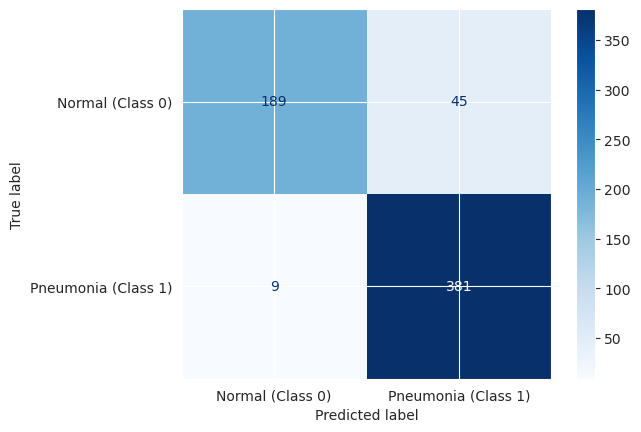

In [41]:
# Chiedi all'utente il focus della classificazione
user_preference = input("Vuoi ridurre (1) Falsi Positivi o (2) Falsi Negativi? Inserisci 1 o 2: ")

# Imposta la soglia in base alla scelta
if user_preference == "1":
    threshold = 0.7  # Riduce FP, ma aumenta FN
elif user_preference == "2":
    threshold = 0.3  # Riduce FN, ma aumenta FP
else:
    threshold = 0.5  # Default

print(f"Utilizzando soglia di {threshold}")

### modello con prima forma di data augmentation
batch_size=32

predictions = cnn_model.predict(test_generator, steps=test_generator.samples // batch_size + 1)
predicted_classes = (predictions > threshold).astype(int)  # Converte le probabilità in classi binarie
y_test = test_generator.classes
# Calcola il report di classificazione
report = classification_report(y_test, predicted_classes, target_names=test_generator.class_indices.keys())
print(report)

cm = confusion_matrix(y_test, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal (Class 0)', 'Pneumonia (Class 1)'])
disp.plot(cmap=plt.cm.Blues)
plt.show()